# **Graph Entity Resolution Demo**

In this colab note I show how to implement a graph based unsupervised entity resolution algorithm. This algorithm is inspired by the paper titled "Unsupervised Entity Resolution with Blocking and Graph Algorithms". The algorithm uses several concepts from graph theory such as bipartite graphs, random walks, SimRank and PageRank. First I will do some imports and load my data files. The algorithm learns similarity between record pairs that share common terms then learns matching probablities between pairs based on the similarity learned. The learned matching probablities are used in an iterative to reinforce the learn similairty and vice versa until convergence.


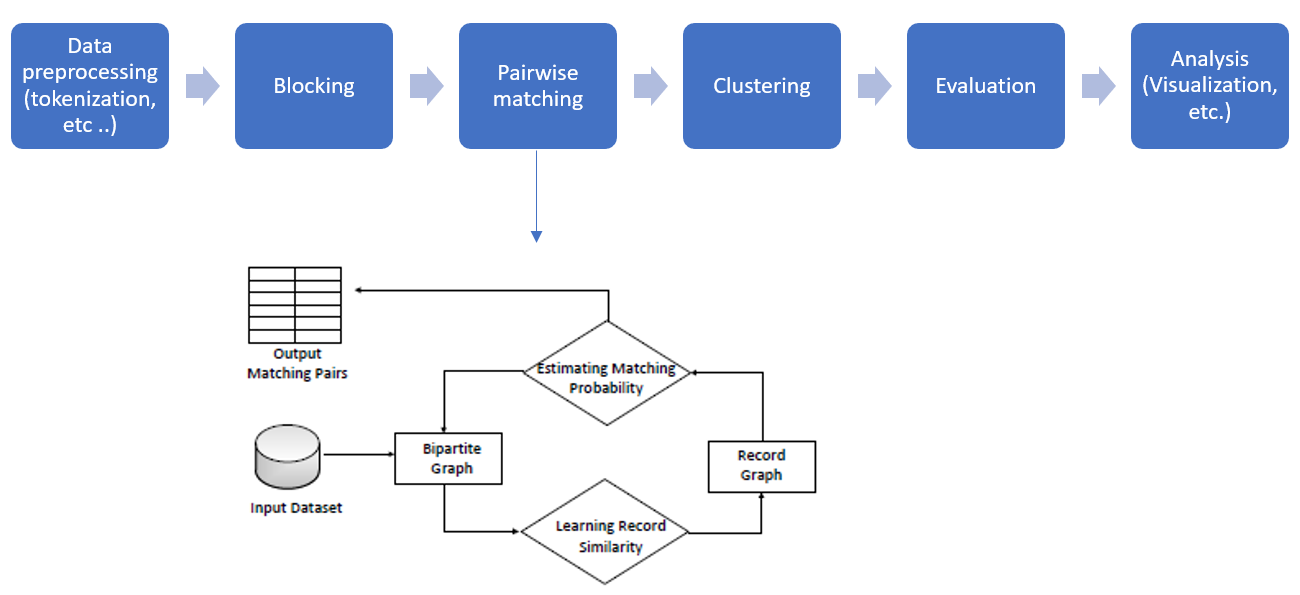

# **Imports**

In [1]:
from google.colab import drive
import pandas as pd
import re
import random
import numpy as np
import operator
from itertools import groupby
from operator import itemgetter
from tqdm import tqdm
import matplotlib.pyplot as plt
import networkx as nx
!pip install python-igraph
import igraph as ig
!pip install stellargraph
import stellargraph as sg

from stellargraph.data import BiasedRandomWalk
from gensim.models import Word2Vec
from sklearn.manifold import TSNE

     |████████████████████████████████| 3.2MB 30.9MB/s 
     |████████████████████████████████| 440kB 23.6MB/s 


Next I mount my drive to load the data

# **Load Data**

In [2]:
drive.mount("/content/drive", force_remount=True)
data_path = "/content/drive/MyDrive/Projects/Education/UALR/Summer 2021/Dissertation/Code/GER/"
data_file = data_path+"data/S1G.txt"
ground_truth_file = data_path+"evaluation/truthABCgoodDQ.txt"

Mounted at /content/drive


First lets take a look at the data set. That will give us an idea of how this process will go.

In [3]:
pd.set_option('display.max_columns', None)

sample_dataframe = pd.read_csv(data_file, sep=",", encoding='utf-8')
print(sample_dataframe.info())
print(sample_dataframe.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   RecID    50 non-null     object
 1   fname    49 non-null     object
 2   lname    50 non-null     object
 3   mname    42 non-null     object
 4   address  50 non-null     object
 5   city     50 non-null     object
 6   state    50 non-null     object
 7   zip      50 non-null     int64 
 8   ssn      46 non-null     object
dtypes: int64(1), object(8)
memory usage: 3.6+ KB
None
     RecID   fname               lname    mname                    address  \
0  A944634     IAN             AADLAND     LARS  29021  HIGH SIERRA TRL      
1  A755471    MYRA   AARGAARD-ESPERSEN      NaN           1224 MAGNOLIA ST   
2  A912696    MYRA  AAARGAARD-ESPERSEN      NaN           1224 MAGNOLIA ST   
3  A813025   ALLEN               AARON   IKAIKA   3830 COUNTRY CLUB RD # J   
4  A824917  ANDREW               AARON  STEPHE

Next I define some utility functions that I will use later.

# **Define: Utility Functions**

In [4]:
def remove_punctuation(str):
    # initializing punctuations string
    punc = '''!()-[]{};:'"\, <>./?@#$%^&*_~'''
    # Removing punctuations in string
    for ele in str:
        if ele in punc:
            str = str.replace(ele, " ")
    return str


def process_token(token):
    processed_token = re.sub(' +', ' ', remove_punctuation(str(token).upper()))
    na = ["NAN","NULL","N/A"]
    if processed_token in na:
        processed_token = processed_token.replace(processed_token, " ")
    return str(processed_token)
    

# Jaccard similarity
def jaccard(s1, s2):
    if len(s1) == 0 and len(s2) == 0:
        return 0
    return float(len(s1&s2) / len(s1|s2))


#Lists all the overlapping ngrams in a string (similar to a sliding window)
def ngrams(seq, n):
    return [seq[i:i+n] for i in range(1+len(seq)-n)]


#Sliding window
def window(fseq, window):
    for i in range(len(fseq) - window + 1):
        yield fseq[i:i+window]


def get_record_node_neighborhood(record_node, target_node, record_graph):
    neighborhood = []
    for record_pair_id, record_graph_dict in record_graph.items():
        if record_graph_dict["source"] == record_node:
            neighborhood.append(record_graph_dict["target"])
        if record_graph_dict["target"] == record_node:
            neighborhood.append(record_graph_dict["source"])
    if target_node in neighborhood:
        neighborhood.remove(target_node)
    if record_node in neighborhood:
        neighborhood.remove(record_node)
    return neighborhood


def get_record_node_neighborhood_for_random_walk(record_node, record_graph):
    neighborhood = []
    for record_pair_id, record_graph_dict in record_graph.items():
        if record_graph_dict["source"] == record_node:
            neighborhood.append(record_graph_dict["target"])
        if record_graph_dict["target"] == record_node:
            neighborhood.append(record_graph_dict["source"])
    if record_node in neighborhood:
        neighborhood.remove(record_node)
    return neighborhood


def get_record_edge_weight(node1, node2, record_graph):
    s = 0
    for record_pair_id, record_graph_dict in record_graph.items():
        pair_node_list = [record_graph_dict["source"], record_graph_dict["target"]]
        if (node1 in pair_node_list) and (node2 in pair_node_list):
            s = record_graph_dict["weight"]
    return s


def get_sum_of_weights_for_neighborhood(node, alpha, record_graph, neighborhood_nodes):
    sum_s = 0
    for nn in neighborhood_nodes:
        s = get_record_edge_weight(node, nn, record_graph)
        sum_s = sum_s + (s ** alpha)
    return sum_s


# Try to find if both nodes exist in the graph. The first node could be in the source
def find_edge(node1, node2, record_graph):
    found_record = 0
    for record_pair_id, record_graph_dict in record_graph.items():
        pair_nodes_list = [record_graph_dict["source"], record_graph_dict["target"]]
        if (node1 in pair_nodes_list) and (node2 in pair_nodes_list):
            found_record = record_graph_dict
        else:
            found_record = 0
    return found_record


def get_pair_node_id(record_pair_id, record_graph):
    for index, record_graph_dict in record_graph.items():
        if index == record_pair_id:
            return record_graph_dict["source"], record_graph_dict["target"]

But first I define some parameters that I will use later.

# **Parameters**

In [5]:
number_of_random_walks = 10
steps = 20
alpha = 20
matching_probability_threshold = 0.98
number_of_grams = 2
ngram_sliding_window_size = 10
number_of_blocks = 5
epochs = 20

Next I token, preprocess and clean the data. I remove punctuation. I also remove dashes and Nans. I then concatinate the tokens into one reference for further processing

# **Tokenization and Preprocessing**

In [6]:
reference_data = {}
for index, row in tqdm(sample_dataframe.iterrows()):
    recID = process_token(row[0])
    fname = process_token(row[1])
    lname = process_token(row[2])
    mname = process_token(row[3])
    address = process_token(row[4])
    city = process_token(row[5])
    state = process_token(row[6])
    zipcode = process_token(row[7])
    ssn = process_token(row[8])
    reference_data[recID] = fname + " " + mname + " " + lname + " " + address + " " + city + " " + state + " " + zipcode + " " + ssn
print(reference_data)

50it [00:00, 5164.38it/s]

{'A944634': 'IAN LARS AADLAND 29021 HIGH SIERRA TRL  SANTA CLARITA CA 91390 490 46 2048', 'A755471': 'MYRA   AARGAARD ESPERSEN 1224 MAGNOLIA ST WINSTON SALEM NC 27103 117 15 8521', 'A912696': 'MYRA   AAARGAARD ESPERSEN 1224 MAGNOLIA ST WINSTON SALEM NC 27103 117158521', 'A813025': 'ALLEN IKAIKA AARON 3830 COUNTRY CLUB RD J WINSTON SALEM NC 27104  ', 'A824917': 'ANDREW STEPHEN AARON 2475 SPICEWOOD DR WINSTON SALEM NC 27106 601 70 6106', 'A875214': 'ANDREEW STEPHEN AARON 2475 SPICEWOOD DR WINSTON SALEM NC 27106 601 70 6106', 'A914099': '  D AARON 1117 E SEVENTEENTH ST WINSTON SALEM NC 27105 636 32 8781', 'A812219': 'CELIA   AARON 1106 LASSEN DR  HANFORD CA 93230 344 37 4232', 'A963930': 'CHRISTOPHER   AARON 2013 WILLIAMSBURG MANOR CT WINSTON SALEM NC 27103 741 75 7354', 'A776838': 'DAVIS SCOTT AAARON 3211 KINNAMON RD WINSTON SALEM NC 27104 834 59 6144', 'A844925': 'DAVIS SCOTT AARON 3211 KINNAMON RD WINSTON SALEM NC 27104 834 59 6144', 'A770538': 'DONALD DWIGHT AARON 6965 WEST RD WALNUT 

Next comes the blocking step. The goal is to quickly find the records that are more likely to match and put them in the same block while making sure that the records that will never match are not grouped in the same block. By definition this step is quadratic so I used the least expensive simiarity operation which is the Jaccard coefficient on a sliding window of bigrams on each pair of records. I first draw a random sample from the records the find the most similar X records using Jaccard. Note that one record could appear in multiple blocks. This might help in the final clustering or transitive closure step.

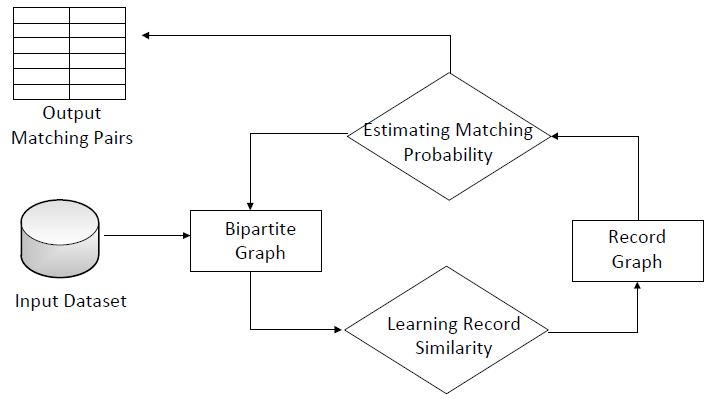

# **Blocking**

In [7]:
C = {}
for s_a in reference_data:
    C[str(s_a)] = str(reference_data[s_a])
# Parameters

# jaccard_threshold = 0.2 # In case we would like to restrict the jaccard similarity

blocks = {}
block_number = 0
for b in range(number_of_blocks):
    block_size = int(len(reference_data)/number_of_blocks)
    block = {}
    record_i_id, record_i = random.sample(list(C.items()),1)[0]
    block[record_i_id] = record_i
    for j in range(block_size):
        record_k = ""
        n1 = ngrams(record_i.lower(), number_of_grams)
        s1 = {''.join(x) for x in window(n1, ngram_sliding_window_size)}
        jaccard_indices = {}
        for key, value in C.items():
            if str(key) != str(record_i_id):
                n2 = ngrams(value.lower(), number_of_grams)
                s2 = {''.join(x) for x in window(n2, ngram_sliding_window_size)}
                jaccard_index = jaccard(s1,s2)
                # if jaccard_index > jaccard_threshold: # In case we would like to restrict the jaccard similarity
                jaccard_indices[key] = jaccard_index
        if jaccard_indices:
            sorted_jaccard_indices = dict(sorted(jaccard_indices.items(), key=operator.itemgetter(1), reverse=True))
            record_k_id = list(sorted_jaccard_indices.keys())[0]
            record_k = C[record_k_id]
            block[record_k_id] = record_k
            del C[record_k_id]
            record_i = record_k
        else:
            continue
    block_number = block_number + 1
    blocks[block_number] = block

for i,block in blocks.items():
    print("Block : " + str(i))
    print("----------------------------------")
    for r_id,r in block.items():
        print(str(r_id) + " : " + str(r))
    print("----------------------------------")

Block : 1
----------------------------------
A935026 : NENA   ABAI IKWECHEGH 4477 LOCHURST DR PFAFFTOWN NC 27040 780 11 8579
A814320 : NENA   ABAI IKWECHEGH 4477 LOCHURST DR PFAFFTOWN NC 27040 780 11 8579
A824044 : NENA   ABAI IKWECHEGH 4477 LOCHURST DR PFAFFTOWN NC 27040 780 11 8579
A948701 : VERONICA OLIVIA AARON 3401 LOCHURST CT PFAFFTOWN NC 27040 335 39 4837
A944634 : IAN LARS AADLAND 29021 HIGH SIERRA TRL  SANTA CLARITA CA 91390 490 46 2048
A755471 : MYRA   AARGAARD ESPERSEN 1224 MAGNOLIA ST WINSTON SALEM NC 27103 117 15 8521
A912696 : MYRA   AAARGAARD ESPERSEN 1224 MAGNOLIA ST WINSTON SALEM NC 27103 117158521
A914099 :   D AARON 1117 E SEVENTEENTH ST WINSTON SALEM NC 27105 636 32 8781
A767794 : TIFFANY   AARON 5122 BURROAK CT WINSTON SALEM NC 27106 937 30 2822
A985464 : LLOYD DEAN AARON 2475 SPICEWOOD DR WINSTON SALEM NC 27106  
A830349 : LLOYD DEAN AARON 2475 SPICEWOOD DR WINSTON SALEM NC 27106 456182098
----------------------------------
Block : 2
------------------------------

Now we can process each block seperatly. In this step the first thing I do is construct a bipartite graph between term nodes and record pair nodes.
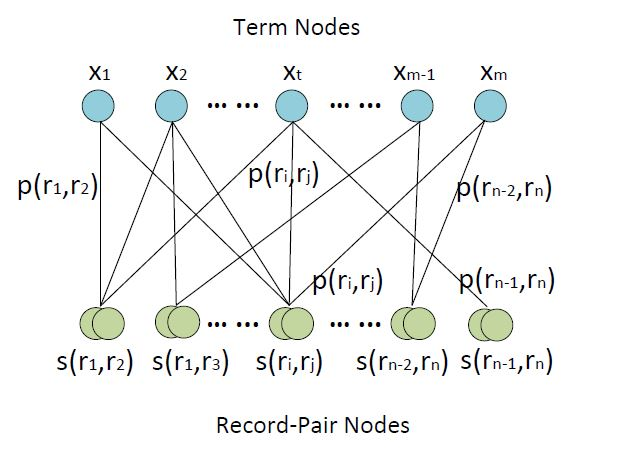

Each unique term in the block is a node that has a weight X_T. Each pair of nodes in the block is a node that also has a similarity score called S. Each node representing a pair of nodes is connected to a term node via an edge with a weight representing the matching probability between the record pair.

The algorithm will run on each block to construct 2 graph: bipartite graph and a record graph


# **Define: Construct Bipartite Graph and Record Graph**

In [8]:
def construct_bipartite_graph(data_block):
  # Create token nodes
  all_tokens = []
  for r_id, r in data_block.items():
      record_tokens = r.split()
      all_tokens = all_tokens + record_tokens
  unique_tokens = np.unique(np.array(all_tokens))
  token_nodes = {}
  j = 0
  for t in unique_tokens:
      x_t = random.uniform(0, 1)
      N_t = 0
      for r_id, r in data_block.items():
          record_tokens = r.split()
          if t in record_tokens:
              N_t = N_t + 1
      token_nodes["T"+str(j)] = {"index": str(j), "token": str(t), "number_of_occurances": int(N_t), "weight": float(x_t)}
      j = j + 1
  # Create record pair nodes
  record_pair_nodes = {}
  i = 0
  for r_1_id, r_1 in data_block.items():
      for r_2_id, r_2 in data_block.items():
          s = 0
          if r_1_id != r_2_id:
              if r_1_id < r_2_id:
                  record_pair_nodes["R"+str(i)] = {"index": str(i), "source": r_1_id, "target": r_2_id, "weight": s}
              if r_2_id < r_1_id:
                  record_pair_nodes["R" + str(i)] = {"index": str(i), "source": r_2_id, "target": r_1_id, "weight": s}
              i = i + 1
  # Create edges
  edges = {}
  to_be_deleted = []
  edge_id = 0
  for pair_node_id, record_pair_dict in record_pair_nodes.items():
      r1 = data_block[record_pair_dict["source"]].split()
      r2 = data_block[record_pair_dict["target"]].split()
      shared_tokens = 0
      for token_node_id, token_dict in token_nodes.items():
          if (token_dict["token"] in r1) and (token_dict["token"] in r2):
              p = random.uniform(0, 1)
              shared_tokens = shared_tokens + 1
              edges[edge_id] = {"source": str(pair_node_id), "target": str(token_node_id), "weight": p}
              edge_id = edge_id + 1
      if shared_tokens == 0:
          to_be_deleted.append(pair_node_id)

  for ob in to_be_deleted:
      del record_pair_nodes[ob]

  return {"term_dict": token_nodes, "record_graph_dict": record_pair_nodes, "bipartite_edges_dict": edges}

Next is the first part of the algorithm that learns the similarity between the record pairs using the edges between each record pair and term nodes in the bipartite graph. There is also the algorithm that learns the matching probabilty. Both algorithms work iteratively meaning in the same loop until convergence.
The first algorithm that learns the similarity works as follows:
- The input is the bipartite graph stucture with initialized P values
- The output is the term node weights and the record pair node weights
- First I initialize the term node weights
- For each record pair we set the node weight as the sum of all term node weights common between both records
- For each term node we compute its weight as the sum of all common record pair nodes weights mulitplied by the edge weight which is the matching probability and normalized
- This process first iterates one time then waits on the update from the second algorithm


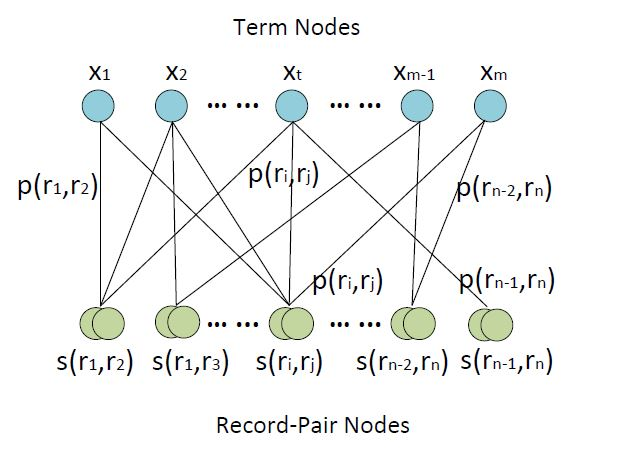


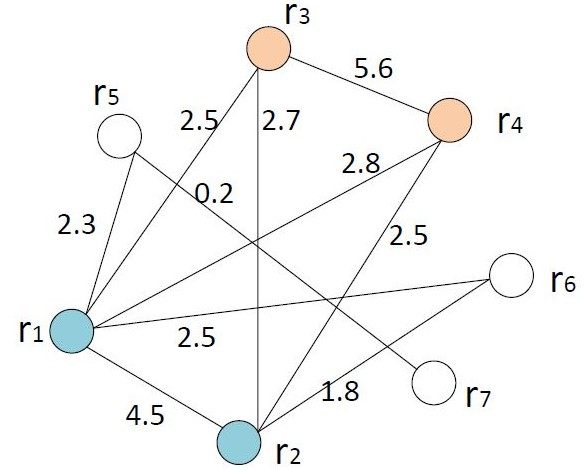

Then inside each block a learning loop runs with both parts of the algorithm; ITER and CliqueRank. Both algorithms reinforce each other.

# **Define: Estimating Record Similarity**

In [9]:
def run_iter(bipartite_graph):
  # {"term_dict": token_nodes, "record_graph_dict": record_pair_nodes, "bipartite_edges_dict": edges}
  term_nodes = bipartite_graph["term_dict"]
  # {"index": int(j), "token": str(t), "number_of_occurances": int(N_t), "weight": float(x_t)}
  record_graph_nodes = bipartite_graph["record_graph_dict"]
  # {"index": int(i), "r1": r_1_id, "r2": r_2_id, "weight": s}
  bipartite_edges = bipartite_graph["bipartite_edges_dict"]
  # {"source": pair_node_id, "target": token_node_id, "weight": p}
  edges_record_nodes = sorted(bipartite_edges.values(), key=itemgetter("source"))
  for key, value in groupby(edges_record_nodes, key=itemgetter("source")):
      for k1 in value:
          record_graph_nodes[key]["weight"] = record_graph_nodes[key]["weight"] + term_nodes[k1["target"]]["weight"]
  edges_term_nodes = sorted(bipartite_edges.values(), key=itemgetter("target"))
  for key, value in groupby(edges_term_nodes, key=itemgetter("target")):
      term_node_weight = term_nodes[key]["weight"]
      for k1 in value:
          p = k1["weight"]
          s = record_graph_nodes[k1["source"]]["weight"]
          N_t = term_nodes[key]["number_of_occurances"]
          P_t = (N_t * (N_t - 1)) / 2
          term_node_weight = term_node_weight + ((p * s) / P_t)
      term_node_weight = (term_node_weight / (term_node_weight + 1))
      term_nodes[key]["weight"] = term_node_weight
      term_node_weight = 0

  return bipartite_graph

Now for the second algorithm the goal is to learn the matching probability between record pairs while updating the first algorithm.

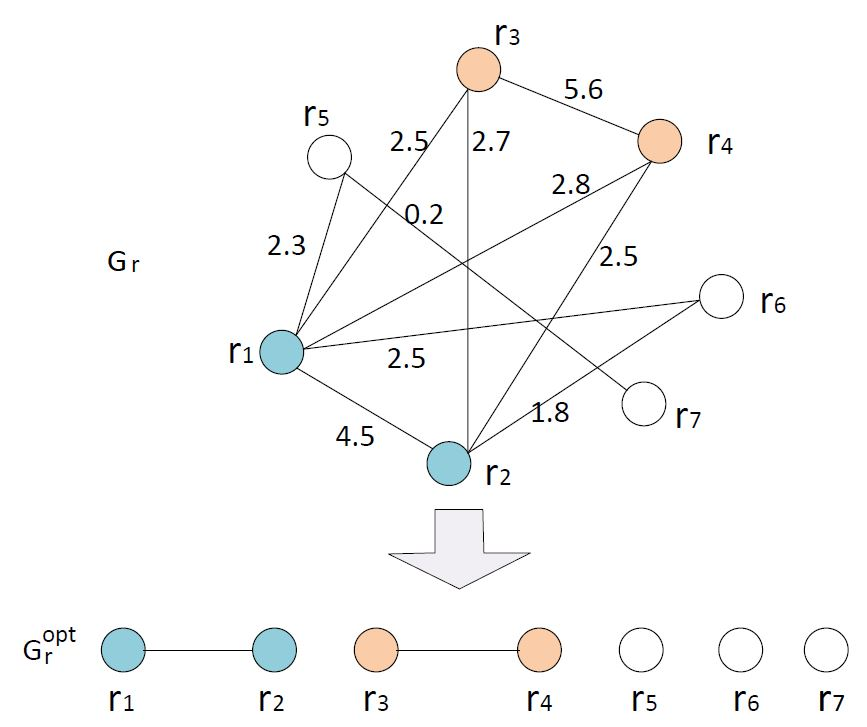

The algorithm works as follows:
- First we forget about the first graph and construct another graph between all records. Where each record is a node and the weight of each edge is the similarirty computed in the first algorithm.
- The output are matching pairs and mathcing probabilities used to feedback in the first algorithm
- The algorithm scans the graph back and forth while scanning it uses random walk simulation between each pair of nodes to compute a matching probability.
- The matching probabilty becomes the number of successfull random walks that can be simulated within a window of steps divided by the total number of walks

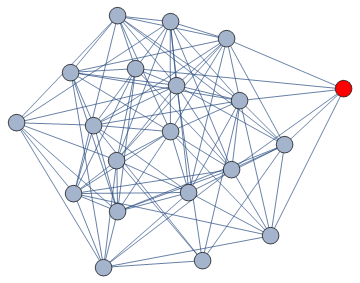

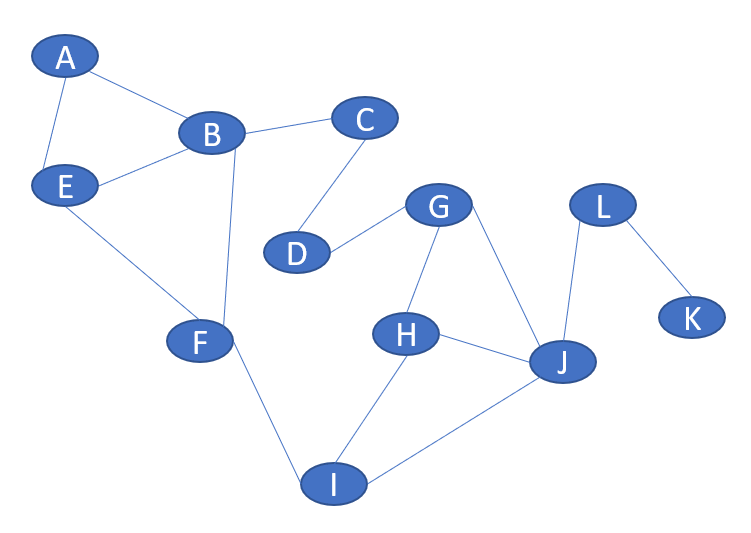

First we define a random walker function that returns 1 for evey succeful walk

In [10]:
def random_walker(start_node, target_node, steps, alpha, record_graph):
  current_node = start_node
  next_node = current_node
  for s in range(0, steps):
      neighborhood_nodes = get_record_node_neighborhood(current_node, target_node, record_graph)
      neighborhood_nodes_for_random_walk = get_record_node_neighborhood_for_random_walk(current_node, record_graph)
      P_bs = {}
      b = random.uniform(0, 1)
      s_current_target = get_record_edge_weight(current_node, target_node, record_graph)
      s_dash_curent_target = ((1 + b) ** alpha) * (s_current_target ** alpha)
      sum_s_r_i_r_k = 0
      for neighbor_node_k in neighborhood_nodes:
          sum_s_r_i_r_k = sum_s_r_i_r_k + (
              float(get_record_edge_weight(current_node, neighbor_node_k, record_graph))) ** alpha
      norm_r_i_r_t = s_dash_curent_target + sum_s_r_i_r_k
      for neighbor_node_j in neighborhood_nodes_for_random_walk:
          b = random.uniform(0, 1)
          s_r_i_r_j = get_record_edge_weight(current_node, neighbor_node_j, record_graph)
          # Calculate P_b
          if neighbor_node_j == target_node:
              numerator_1 = ((1 + b) ** alpha) * (s_r_i_r_j ** alpha)
              P_b_1 = numerator_1 / norm_r_i_r_t
              P_bs[neighbor_node_j] = P_b_1
          else:
              numerator_2 = (s_r_i_r_j ** alpha)
              P_b_2 = numerator_2 / norm_r_i_r_t
              P_bs[neighbor_node_j] = P_b_2
      sorted_P_bs = dict(sorted(P_bs.items(), key=operator.itemgetter(1), reverse=True))
      next_node = next(iter(sorted_P_bs.keys()))
      found_edge = find_edge(next_node, target_node, record_graph)
      if next_node == target_node:
          return 1
      if found_edge == 0:
          return 0
      current_node = next_node
  return 0

Then I define a random surfer function that counts the successfull walks back and forth

In [11]:
def random_surfer(record_graph, number_of_random_walks, steps, alpha):
  # {"source":source, "target":target, "weight": weight_s}
  for record_pair_id, record_graph_dict in record_graph.items():
      r_i = record_graph_dict["source"]
      r_j = record_graph_dict["target"]
      c_1 = 0
      c_2 = 0
      for m in range(0, int(number_of_random_walks / 2)):
          c_1 = c_1 + random_walker(r_i, r_j, steps, alpha, record_graph)
      for m in range(0, int(number_of_random_walks / 2)):
          c_2 = c_2 + random_walker(r_j, r_i, steps, alpha, record_graph)
      p_i_j = float((c_1 + c_2) / number_of_random_walks)
      record_graph_dict["matching_prob"] = float(p_i_j)

Now after computing the matching probability I need to update my graph weights so that I can feedback to the first algorithm.

# **Define: Estimating Matching Probability**

In [12]:
def run_clique_rank(bipartite_graph, number_of_random_walks, steps, alpha):
  record_graph = bipartite_graph["record_graph_dict"]
  bipartite_edges = bipartite_graph["bipartite_edges_dict"]
  random_surfer(record_graph, number_of_random_walks, steps, alpha)
  # {"source": pair_node_id, "target": token_node_id, "weight": p}
  for be_index, be_row in bipartite_edges.items():
      # I need to find pair node id
      source_node, target_node = get_pair_node_id(be_row["source"], record_graph)
      if source_node and target_node:
          found_record_edge = find_edge(source_node, target_node, record_graph)
          if found_record_edge != 0:
              be_row["weight"] = found_record_edge["matching_prob"]
  return bipartite_graph

Now we define the matching function:
1- We threshold the final matching probability (it is expected to be close to 1)
2- We include records that do not have matches

# **Define: The Final Matching Step**

In [13]:
def match(original_data_frame, bipartite_graph, final_matches, matching_probability_threshold):
  print("Matching")

  def list_difference(list_1, list_2):
    return list(set(list_1) - set(list_2)) + list(set(list_2) - set(list_1))
    
  record_graph_nodes = bipartite_graph["record_graph_dict"]
  # {"source": pair_node_id, "target": token_node_id, "weight": p}
  for be_index, be_dict in record_graph_nodes.items():
      if be_dict["matching_prob"] > matching_probability_threshold:
          final_matches.append((be_dict["source"], be_dict["target"]))

  # Validate final matches

  first_row = []
  second_row = []
  for e in final_matches:
      first_row.append(e[0])
      second_row.append(e[1])
  unique_records = np.unique(np.array(first_row+second_row)).tolist()
  all_records = original_data_frame["RecID"].tolist()
  single_clusters_list = list_difference(all_records,unique_records)
  single_clusters = []
  for r in single_clusters_list:
      single_clusters.append((r,r))

  final_matches = final_matches + single_clusters

  return final_matches

Now I can construct my main learning loop.

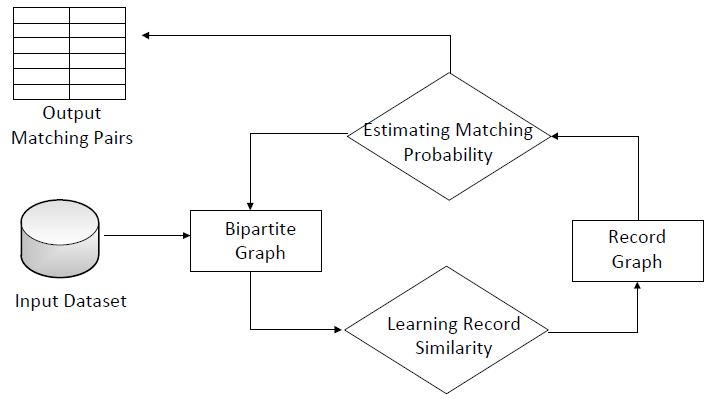

# **Learning Loop**

In [14]:
bipartite_graph = {}
final_matches = []
# Controller
for i,block in tqdm(blocks.items()):
  print("\nProcessing block : " + str(i))
  # Construct graph
  bipartite_graph = construct_bipartite_graph(block)
  # {"term_dict": token_nodes, "record_graph_dict": record_pair_nodes, "bipartite_edges_dict": edges}
  term_nodes = bipartite_graph["term_dict"]
  # {"index": int(j), "token": str(t), "number_of_occurances": int(N_t), "weight": float(x_t)}
  record_graph_nodes = bipartite_graph["record_graph_dict"]
  # {"index": int(i), "r1": r_1_id, "r2": r_2_id, "weight": s}
  bipartite_edges = bipartite_graph["bipartite_edges_dict"]
  # {"source": pair_node_id, "target": token_node_id, "weight": p}
  print("\n----------------------------------------")
  print("Number of tokens: " + str(len(term_nodes)))
  print("Number of pair nodes: " + str(len(record_graph_nodes)))
  print("Number of bipartite edges: " + str(len(bipartite_edges)))
  print("Number of record-record edges: " + str(len(record_graph_nodes)))
  print("----------------------------------------")
  for e in range(epochs):
      # ITER
      bipartite_graph = run_iter(bipartite_graph)
      # CliqueRank
      bipartite_graph = run_clique_rank(bipartite_graph, number_of_random_walks, steps, alpha)
  # Matching
  print("\nMatching")
  final_matches = match(sample_dataframe, bipartite_graph, final_matches, matching_probability_threshold)

  0%|          | 0/5 [00:00<?, ?it/s]


Processing block : 1

----------------------------------------
Number of tokens: 68
Number of pair nodes: 90
Number of bipartite edges: 300
Number of record-record edges: 90
----------------------------------------


 20%|██        | 1/5 [00:12<00:48, 12.12s/it]


Matching
Matching

Processing block : 2

----------------------------------------
Number of tokens: 56
Number of pair nodes: 110
Number of bipartite edges: 378
Number of record-record edges: 110
----------------------------------------


 40%|████      | 2/5 [00:31<00:42, 14.21s/it]


Matching
Matching

Processing block : 3

----------------------------------------
Number of tokens: 62
Number of pair nodes: 110
Number of bipartite edges: 564
Number of record-record edges: 110
----------------------------------------


 60%|██████    | 3/5 [00:50<00:31, 15.72s/it]


Matching
Matching

Processing block : 4

----------------------------------------
Number of tokens: 69
Number of pair nodes: 100
Number of bipartite edges: 344
Number of record-record edges: 100
----------------------------------------


 80%|████████  | 4/5 [01:05<00:15, 15.51s/it]


Matching
Matching

Processing block : 5

----------------------------------------
Number of tokens: 89
Number of pair nodes: 86
Number of bipartite edges: 166
Number of record-record edges: 86
----------------------------------------


100%|██████████| 5/5 [01:15<00:00, 15.18s/it]


Matching
Matching


# **Clustering**

In [15]:
def cluster(final_matches):
  G = nx.Graph()
  G.add_edges_from(final_matches)
  cluster_list = []

  #Informap
  g_ig = ig.Graph.Adjacency(
      (nx.to_numpy_matrix(G) > 0).tolist(), mode=ig.ADJ_UNDIRECTED
  )
  random.seed(123)
  c_infomap = g_ig.community_infomap()
  for clusters in c_infomap:
      for node in clusters:
          cluster_list.append((str(list(G.nodes)[int(clusters[0])]), str(list(G.nodes)[int(node)])))

  # #Louvain
  # clusters = community_louvain.best_partition(G)

  return cluster_list

# **Evaluation**

In [16]:
# This function is part of the DWM version 1.5
def evaluate_clusters(cluster_list, ground_truth_file):
  print("Evaluate clusters")
  def countPairs(dict):
      totalPairs = 0
      for cnt in dict.values():
          pairs = cnt*(cnt-1)/2
          totalPairs +=pairs
      return totalPairs
  erDict = {}
  for pair in cluster_list:
      clusterID = pair[0]
      refID = pair[1]
      newPair = (clusterID,'x')
      erDict[refID] = newPair
  truthFile = open(ground_truth_file,'r')
  line = (truthFile.readline()).strip()
  while line != '':
      part = line.split(',')
      recID = part[0].strip()
      truthID = part[1].strip()
      if recID in erDict:
          oldPair = erDict[recID]
          clusterID = oldPair[0]
          newPair = (clusterID, truthID)
          erDict[recID] = newPair
      line = (truthFile.readline()).strip()
  linkedPairs = {}
  equivPairs = {}
  truePos = {}
  for pair in tqdm(erDict.values()):
      clusterID = pair[0]
      truthID = pair[1]
      if pair in truePos:
          cnt = truePos[pair]
          cnt +=1
          truePos[pair] = cnt
      else:
          truePos[pair] = 1
      if clusterID in linkedPairs:
          cnt = linkedPairs[clusterID]
          cnt +=1
          linkedPairs[clusterID] = cnt
      else:
          linkedPairs[clusterID] = 1
      if truthID in equivPairs:
          cnt = equivPairs[truthID]
          cnt +=1
          equivPairs[truthID] = cnt
      else:
          equivPairs[truthID] = 1
  # End of counts
  L = countPairs(linkedPairs)
  E = countPairs(equivPairs)
  TP = countPairs(truePos)
  print('L=',L,'E=',E, 'TP=', TP)
  FP = float(L-TP)
  FN = float(E-TP)
  precision = round(TP/float(L),4)
  recall = round(TP/float(E),4)
  fmeas = round((2*precision*recall)/(precision+recall),4)
  print('Precision=',precision)
  print('Recall=', recall)
  print('F-measure=', fmeas)
  return

# **Visualize and Analyze**

In [17]:
def visualize(edges, nodes):

  def get_node_type(node, nodes):
      type = ""
      for n in nodes:
          if n[1] == node:
              type = n[0]
      return type

  source_nodes = []
  target_nodes = []
  for e in edges:
      source = e[0]
      target = e[1]
      source_nodes.append(source)
      target_nodes.append(target)
  edges_data_frame = pd.DataFrame(
      {"source": source_nodes, "target": target_nodes}
  )
  graph = sg.StellarGraph(edges=edges_data_frame)
  print(graph.info())
  rw = BiasedRandomWalk(graph)

  walks = rw.run(
      nodes=list(graph.nodes()),  # root nodes
      length=100,  # maximum length of a random walk
      n=10,  # number of random walks per root node
      p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
      q=2.0,  # Defines (unormalised) probability, 1/q, for moving away from source node
  )
  print("Number of random walks: {}".format(len(walks)))
  str_walks = [[str(n) for n in walk] for walk in walks]
  model = Word2Vec(str_walks, size=128, window=3, negative=5, min_count=0, sg=1, hs=0, workers=8, iter=10, sample=0)

  # Retrieve node embeddings and corresponding subjects
  node_ids = model.wv.index2word  # list of node IDs
  node_embeddings = (
      model.wv.vectors
  )  # numpy.ndarray of size number of nodes times embeddings dimensionality
  node_targets = [get_node_type(node_id, nodes) for node_id in node_ids]
  # node_targets = node_subjects[[int(node_id) for node_id in node_ids]]

  # Apply t-SNE transformation on node embeddings
  tsne = TSNE(n_components=2)
  node_embeddings_2d = tsne.fit_transform(node_embeddings)

  # draw the points
  alpha = 1.0
  label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
  node_colours = [label_map[target] for target in node_targets]

  plt.figure(figsize=(10, 8))
  plt.scatter(
      node_embeddings_2d[:, 0],
      node_embeddings_2d[:, 1],
      c=node_colours,
      cmap="tab20",
      alpha=alpha,
  )

  #figure out edges
  # edge_lines_x = []
  # edge_lines_y = []
  # for e in graph.edges():
  #     source_node = e[0]
  #     target_node = e[1]
  #     edge_lines_x.append(node_embeddings_2d[int(model.wv.key_to_index[source_node]), 0])
  #     edge_lines_x.append(node_embeddings_2d[int(model.wv.key_to_index[target_node]), 0])
  #     edge_lines_y.append(node_embeddings_2d[int(model.wv.key_to_index[source_node]), 1])
  #     edge_lines_y.append(node_embeddings_2d[int(model.wv.key_to_index[target_node]), 1])

  # plt.plot(edge_lines_x, edge_lines_y, alpha=0.3)

  plt.show()

Now run the analysis

Clustering
Evaluating
Evaluate clusters


100%|██████████| 50/50 [00:00<00:00, 7110.19it/s]


L= 29.0 E= 27.0 TP= 21.0
Precision= 0.7241
Recall= 0.7778
F-measure= 0.75
Visualizing
StellarGraph: Undirected multigraph
 Nodes: 50, Edges: 91

 Node types:
  default: [50]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [91]
        Weights: all 1 (default)
        Features: none
Number of random walks: 500


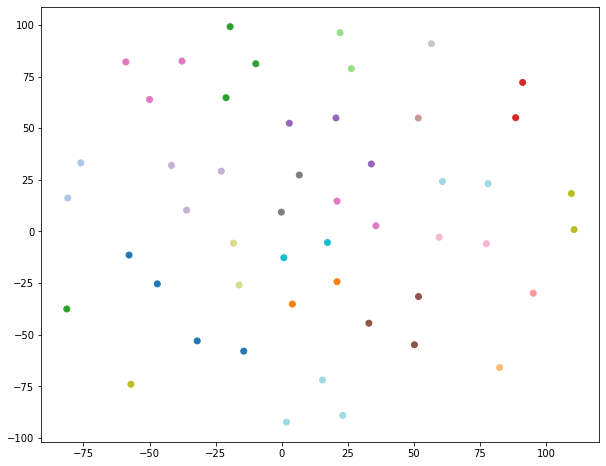

In [18]:
print("Clustering")
cluster_list = cluster(final_matches)
print("Evaluating")
evaluate_clusters(cluster_list, ground_truth_file)
print("Visualizing")
visualize(final_matches, cluster_list)